In [4]:
# 패키지 임포트
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy.optimize import minimize

sns.set()

### 데이터셋 준비
총 16개 ETF에 대한 가격 데이터를 다운로드 (월간 데이터)

In [5]:
# ETF 데이터 다운로드
tickers = ['XLB', 'XLE', 'XLF', 'XLI', 'XLK', 'XLP', 'XLU', 'XLV', 'XLY']
etf = yf.Tickers(tickers)
data = etf.history(start='2010-01-01', actions=False)
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)

data = data.droplevel(0, axis=1).resample('M').last()

[*********************100%***********************]  9 of 9 completed


In [6]:
# 수익률 계산
rets = data.pct_change().fillna(0)

In [7]:
# 색깔 팔레트
# 기본 팔레트의 경우 갯수가 많아지면 색상이 겹침
pal = sns.color_palette('Spectral', len(tickers))

### 동일 비중 계산

In [8]:
# 가중치 계산 함수
def get_ew_weights(rets):
    noa = len(rets.columns)
    # ones_like 입력된 배열과 동일한 형태의 행렬을 만들고 1로 채움
    weights = np.ones_like(rets) * (1/noa)
    return weights

# 동일가중치
weights = get_ew_weights(rets)[-1]

In [10]:
weights

array([0.11111111, 0.11111111, 0.11111111, 0.11111111, 0.11111111,
       0.11111111, 0.11111111, 0.11111111, 0.11111111])

### 동일 비중 파이차트 시각화

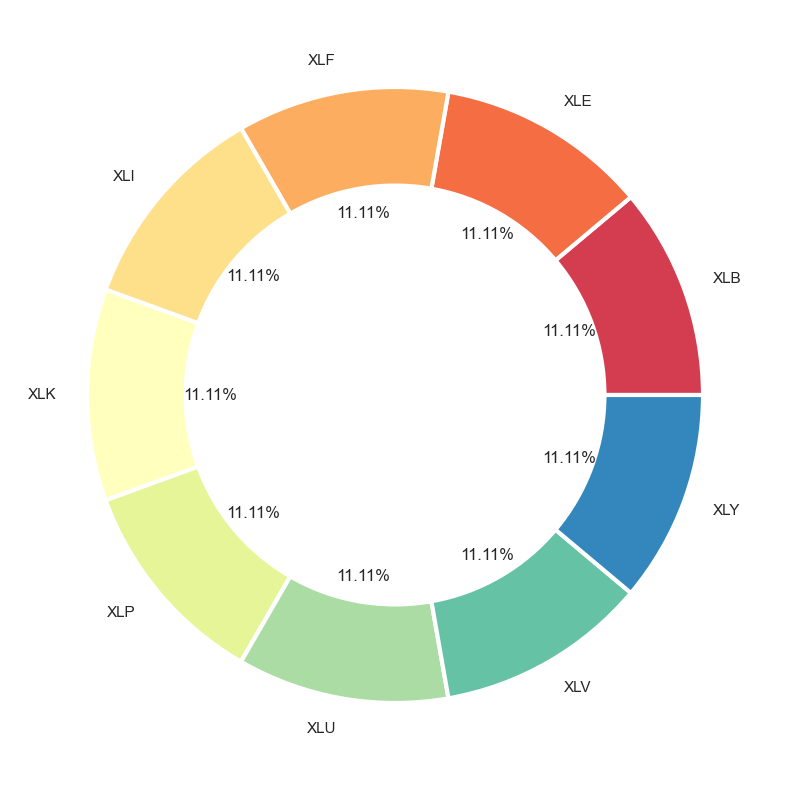

In [13]:
# 파이차트 시각화
plt.figure(figsize=(10, 10))
# wedgeprop 파이차트 사이의 틈을 어떻게 할지 정의 
## width : 파이 차트 사이 공간, edgecolor : 공간의 색상, lineweidth : 파이 차트 굵기
wedgeprops = {'width': 0.32, 'edgecolor': 'w', 'linewidth': 3}
# autopct : % 숫자 표시 방식
plt.pie(weights, labels=tickers, autopct='%.2f%%', wedgeprops=wedgeprops, colors=pal)
plt.show()

### 동일 비중 시계열 플랏 생성

Text(0, 0.5, 'weights')

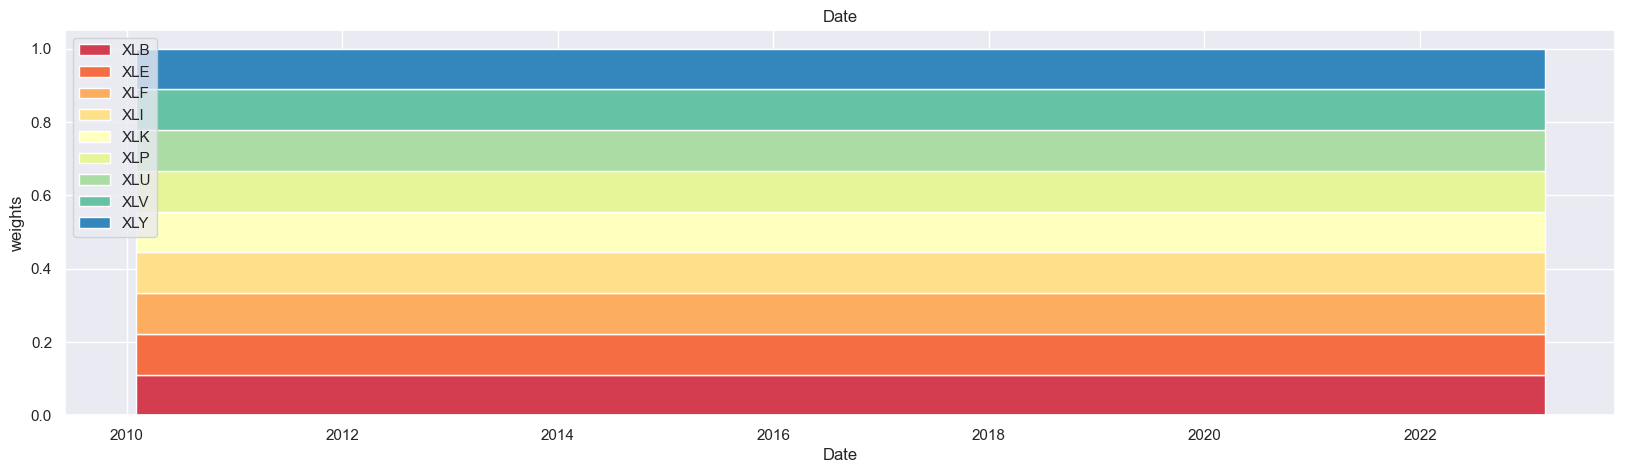

In [14]:
# 시계열 가중치 데이터프레임
ew_w_df = pd.DataFrame(get_ew_weights(rets), index=rets.index, columns=rets.columns)

# 그래프 결과
plt.figure(figsize=(20, 5))
plt.stackplot(ew_w_df.index, ew_w_df.T, labels=ew_w_df.columns, colors=pal)
plt.legend(loc='upper left')
plt.title('Date')
plt.xlabel('Date')
plt.ylabel('weights')

### 동일 비중 포트폴리오 백테스팅 결과

Text(0, 0.5, 'Returns')

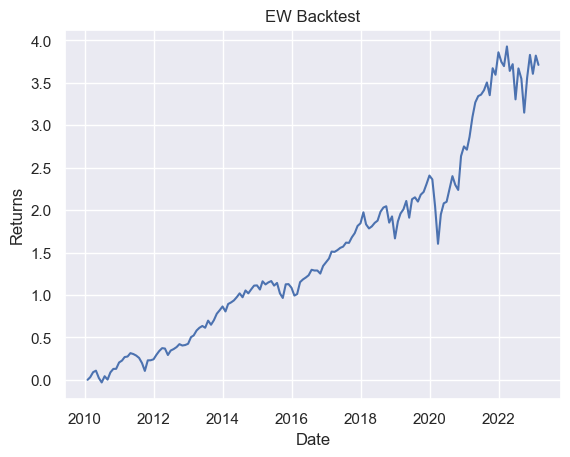

In [16]:
# 동일 비중 포트폴리오 수익률
# shift : return 값과 시점 맞추기 위해
port_rets = ew_w_df.shift() * rets

# 포트폴리오 누적 수익률
## 포트폴리오 수익률 합계를 구하고 수익률 누적곱
## 처음에 (1+ret)로 시작했으므로 마지막에 -1
port_cum_rets = (1 + port_rets.sum(axis=1)).cumprod() - 1

# 그래프 결과
plt.plot(port_cum_rets)
plt.title('EW Backtest')
plt.xlabel('Date')
plt.ylabel('Returns')